In [1]:
import pandas as pd
# SAGE 상위 이상치 확인
df = pd.read_csv('recon_errors_SAGE_AE.csv')
print('총 검증 수:', len(df))
print('z>3 개수:', df['anomaly_z3'].sum())
print(df.sort_values('zscore', ascending=False).head(20))


총 검증 수: 1592
z>3 개수: 4
      node_index                                     address  recon_error  \
1558        7797  0x99a7f147a106fc8d0f650175e095a31c198fd94f    355650.72   
1535        7675  0xad3bd66b13848352346aec626ef1100a8ff05b22    355644.97   
651         3310  0xf251c6769912461607bff0cd9998b50b5fba901a    224281.03   
196         1066  0x2c62f232dfa0ed525ee489d0ef3fc0e43516e8ce    224281.02   
234         1279  0x4b4571f69934099d0c2fda3d87506aed78ed5857    182329.06   
199         1077  0x9975f665a5d9f1892e7b4e6ae4a7bf43a148b29b    182329.06   
185         1012  0x144b09d293ad65915fd8a68319a9efcc54c3c4c4    182329.05   
201         1082  0x9b6606b9aea965dc920e0cb5fae1d0f2d975d4f8    182329.05   
606         3118  0x7594300a202551d1eb7a7920be92bf4e1e11365c    166455.89   
419         2204  0x82ed92f58635f21490602ab9948750cad42ed940    166455.89   
293         1636  0xd76c3fbf029b0b88060c2236f7cf07f3d2f1e3fd    166455.88   
212         1155  0xfc1511825331db9abe2634f27f82f7a1c

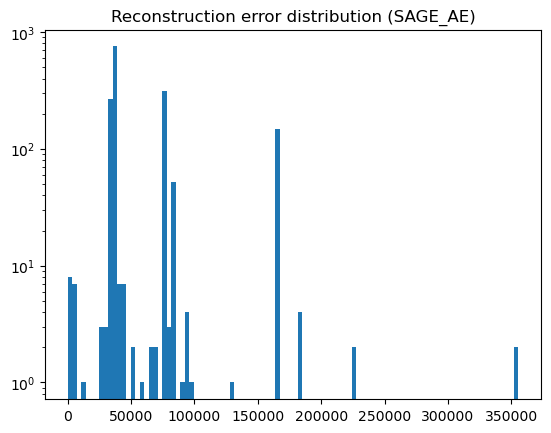

In [2]:

# 분포 확인
import matplotlib.pyplot as plt
plt.hist(df['recon_error'], bins=100)
plt.yscale('log')
plt.title('Reconstruction error distribution (SAGE_AE)')
plt.show()

In [3]:
# NetworkX 시각화로 이상치 원인 탐색
# - recon_errors_SAGE_AE.csv의 이상치(address)들을 그래프 상에서 시각화(ego network)
# - 각 이상치에 대해 in/out degree, 총 입출금(netValue 합) 등을 출력하여 원인 단서 제공

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import os

# 설정
CSV = 'recon_errors_SAGE_AE.csv'
GRAPH_PATH = 'G_graph.gpickle'
TOP_K = 5  # 시각화할 상위 이상치 수
RADIUS = 1  # ego graph 반경


In [4]:

# 1) 데이터 로드
if not os.path.exists(CSV):
    raise FileNotFoundError(f'{CSV} not found')

df = pd.read_csv(CSV)

# 우선 z>3 이상치 우선 표시, 없으면 상위 TOP_K 사용
anoms_z3 = df.loc[df['anomaly_z3']].sort_values('zscore', ascending=False)
if len(anoms_z3) > 0:
    sel = anoms_z3.head(TOP_K)
else:
    sel = df.sort_values('zscore', ascending=False).head(TOP_K)

print('Selected anomalies to visualize:')
print(sel[['node_index','address','recon_error','zscore']])

# 2) 그래프 로드
try:
    try:
        G = nx.read_gpickle(GRAPH_PATH)
    except AttributeError:
        with open(GRAPH_PATH, 'rb') as f:
            G = pickle.load(f)
    print(f'Loaded graph: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}')
except Exception as e:
    raise RuntimeError(f'Failed to load graph: {e}')


Selected anomalies to visualize:
      node_index                                     address  recon_error  \
1558        7797  0x99a7f147a106fc8d0f650175e095a31c198fd94f    355650.72   
1535        7675  0xad3bd66b13848352346aec626ef1100a8ff05b22    355644.97   
651         3310  0xf251c6769912461607bff0cd9998b50b5fba901a    224281.03   
196         1066  0x2c62f232dfa0ed525ee489d0ef3fc0e43516e8ce    224281.02   

        zscore  
1558  7.217715  
1535  7.217575  
651   4.011053  
196   4.011053  
Loaded graph: nodes=7958, edges=14128


In [6]:
# 이상치 주소의 원 데이터(트랜잭션) 기반 원인 분석
# - picaartmoney_transactions_full.csv에서 해당 주소의 입출금 패턴을 추출하여
#   거래 횟수, 총액(보정된 value), 상위 상대방, 특정 일자 스파이크 등을 확인합니다.

import pandas as pd
import numpy as np
from datetime import datetime

TX_CSV = 'picaartmoney_transactions_full.csv'
if not os.path.exists(TX_CSV):
    raise FileNotFoundError(f'{TX_CSV} not found')

# 원본 트랜잭션 로드 (문자열로 읽은 뒤 숫자 변환)
df_tx = pd.read_csv(TX_CSV, dtype=str)
# 필요한 컬럼이 문자열로 있을 수 있으므로 안전하게 변환
for c in ['value','tokenDecimal','timeStamp']:
    if c in df_tx.columns:
        df_tx[c] = pd.to_numeric(df_tx[c], errors='coerce').fillna(0)

# value_adjusted 계산
if 'tokenDecimal' in df_tx.columns and 'value' in df_tx.columns:
    df_tx['value_adjusted'] = df_tx['value'] / (10 ** df_tx['tokenDecimal']).astype(float)
else:
    df_tx['value_adjusted'] = pd.to_numeric(df_tx.get('value', 0), errors='coerce').fillna(0)

# day 컬럼
if 'timeStamp' in df_tx.columns:
    df_tx['day'] = pd.to_datetime(df_tx['timeStamp'], unit='s', errors='coerce').dt.date
else:
    df_tx['day'] = pd.NaT

# 분석할 주소 목록 (앞서 선택한 sel이 없다면 상위 zscore 사용)
try:
    addresses = sel['address'].tolist()
except NameError:
    # 셀에서 sel 변수가 없으면 파일에서 z>3 우선 선택
    df_recon = pd.read_csv('recon_errors_SAGE_AE.csv')
    add_z3 = df_recon.loc[df_recon['anomaly_z3']].sort_values('zscore', ascending=False)
    addresses = add_z3['address'].head(5).tolist() if len(add_z3)>0 else df_recon.sort_values('zscore', ascending=False).head(5)['address'].tolist()

print('Analyzing addresses:', addresses)


Analyzing addresses: ['0x99a7f147a106fc8d0f650175e095a31c198fd94f', '0xad3bd66b13848352346aec626ef1100a8ff05b22', '0xf251c6769912461607bff0cd9998b50b5fba901a', '0x2c62f232dfa0ed525ee489d0ef3fc0e43516e8ce']


In [8]:
# 이상치 주소의 트랜잭션 해시/메소드 동시성 요약
import pandas as pd

df_recon = pd.read_csv('recon_errors_SAGE_AE.csv')
add_z3 = df_recon.loc[df_recon['anomaly_z3']].sort_values('zscore', ascending=False)
if len(add_z3)==0:
    add_z3 = df_recon.sort_values('zscore', ascending=False).head(5)
addrs = add_z3['address'].tolist()

tx = pd.read_csv('picaartmoney_transactions_full.csv', dtype=str)
# ensure value adjusted
if 'value' in tx.columns and 'tokenDecimal' in tx.columns:
    tx['value'] = pd.to_numeric(tx['value'], errors='coerce').fillna(0)
    tx['tokenDecimal'] = pd.to_numeric(tx['tokenDecimal'], errors='coerce').fillna(0).astype(int)
    tx['value_adjusted'] = tx['value'] / (10 ** tx['tokenDecimal']).astype(float)
else:
    tx['value_adjusted'] = pd.to_numeric(tx.get('value',0), errors='coerce').fillna(0)

for addr in addrs:
    sub = tx[(tx['from']==addr) | (tx['to']==addr)].copy()
    print('\nAddress:', addr, 'transactions found:', len(sub))
    if sub.empty:
        continue
    # group by hash
    by_hash = sub.groupby('hash').agg(count=('hash','size'), total_val=('value_adjusted','sum')).sort_values('count', ascending=False)
    print('Top hashes by occurrence:')
    print(by_hash.head(10))
    # methodId/functionName
    for k in ['methodId','functionName']:
        if k in sub.columns:
            print('\nTop', k, 'values:')
            print(sub[k].value_counts().head(10))
    # show if many different addresses share same hash (multi-send)
    multi_hashes = by_hash.loc[by_hash['count']>1]
    if not multi_hashes.empty:
        print('\nPotential multisend hashes (count>1):')
        print(multi_hashes.head(10))
    else:
        print('\nNo multisend-like hashes detected for this address (by count>1)')

print('\nDone.')



Address: 0x99a7f147a106fc8d0f650175e095a31c198fd94f transactions found: 4
Top hashes by occurrence:
                                                    count    total_val
hash                                                                  
0x268083a6555a5017d66e7d48832e13b9bbce72fd06126...      1   26000000.0
0x5f46d2e8d64fd5dd277147ddae8e8929173a4faacc43a...      1          1.0
0x5fb52b768a1f1a9acde1741bc77773fe4e22bb0aca0b9...      1  370000000.0
0xbd81397484e08a3441264ec4acd73c6640a1b639207ff...      1   26854724.0

Top methodId values:
methodId
0xa9059cbb    4
Name: count, dtype: int64

Top functionName values:
functionName
transfer(address _to, uint256 _value)    4
Name: count, dtype: int64

No multisend-like hashes detected for this address (by count>1)

Address: 0xad3bd66b13848352346aec626ef1100a8ff05b22 transactions found: 1
Top hashes by occurrence:
                                                    count  total_val
hash                                                     

In [9]:

# 분석 루프
for addr in addresses:
    print('\n' + '='*60)
    print('Address:', addr)
    sub = df_tx[(df_tx['from']==addr) | (df_tx['to']==addr)].copy()
    if sub.empty:
        print('  No transactions found in CSV for this address')
        continue
    sub['direction'] = np.where(sub['from']==addr, 'out', 'in')
    total_in = sub.loc[sub['direction']=='in','value_adjusted'].sum()
    total_out = sub.loc[sub['direction']=='out','value_adjusted'].sum()
    cnt_in = sub.loc[sub['direction']=='in'].shape[0]
    cnt_out = sub.loc[sub['direction']=='out'].shape[0]
    first_ts = int(sub['timeStamp'].min()) if 'timeStamp' in sub.columns else None
    last_ts = int(sub['timeStamp'].max()) if 'timeStamp' in sub.columns else None
    print(f'  count_in={cnt_in}  count_out={cnt_out}  total_in={total_in:.6f}  total_out={total_out:.6f}')
    if first_ts:
        print('  first_tx:', datetime.utcfromtimestamp(first_ts))
        print('  last_tx :', datetime.utcfromtimestamp(last_ts))

    # 상위 상대방 (카운트 기준)
    sub['counterparty'] = np.where(sub['from']==addr, sub['to'], sub['from'])
    top_counter_by_cnt = sub['counterparty'].value_counts().head(10)
    top_counter_by_val = sub.groupby('counterparty')['value_adjusted'].sum().sort_values(ascending=False).head(10)
    print('\n  Top counterparties (by count):')
    print(top_counter_by_cnt)
    print('\n  Top counterparties (by total value):')
    print(top_counter_by_val)

    # 일별 합계로 스파이크 확인
    day_sum = sub.groupby('day')['value_adjusted'].sum().sort_values(ascending=False)
    print('\n  Top days by total value:')
    print(day_sum.head(10))

    # 거래 유형 요약 (methodId / functionName 존재 시)
    for key in ['methodId','functionName','input']:
        if key in sub.columns:
            vals = sub[key].value_counts().head(5)
            if not vals.empty:
                print(f"\n  Top {key} values:\n", vals)

    # 샘플 트랜잭션 출력(최신 10건)
    print('\n  Sample latest transactions:')
    disp_cols = ['timeStamp','from','to','value','tokenDecimal','value_adjusted','hash']
    exist_cols = [c for c in disp_cols if c in sub.columns]
    display(sub.sort_values('timeStamp', ascending=False)[exist_cols].head(10))

    # 간단한 판정(거래소/컨트랙트 의심 기준 예시)
    # - 매우 많은 수신/발신 카운트와 하나의 상대에 집중되어 있으면(예: top counterparty 비율 > 0.6) 거래소 관련일 가능성
    top_cnt = top_counter_by_cnt.iloc[0] if not top_counter_by_cnt.empty else 0
    if (cnt_in+cnt_out)>0 and top_cnt / (cnt_in+cnt_out) > 0.6:
        print('\n  Note: 거래가 특정 상대에 매우 집중되어 있음 -> 전형적 입출금/중개 주소 또는 스크립트에 의한 대량 송금 가능성')

print('\nAnalysis complete.')




Address: 0x99a7f147a106fc8d0f650175e095a31c198fd94f
  count_in=4  count_out=0  total_in=422854725.000000  total_out=0.000000
  first_tx: 2021-10-22 07:37:37
  last_tx : 2021-10-26 02:17:19

  Top counterparties (by count):
counterparty
0x167a9333bf582556f35bd4d16a7e80e191aa6476    4
Name: count, dtype: int64

  Top counterparties (by total value):
counterparty
0x167a9333bf582556f35bd4d16a7e80e191aa6476    422854725.0
Name: value_adjusted, dtype: float64

  Top days by total value:
day
2021-10-22    370000001.0
2021-10-25     26854724.0
2021-10-26     26000000.0
Name: value_adjusted, dtype: float64

  Top methodId values:
 methodId
0xa9059cbb    4
Name: count, dtype: int64

  Top functionName values:
 functionName
transfer(address _to, uint256 _value)    4
Name: count, dtype: int64

  Top input values:
 input
deprecated    4
Name: count, dtype: int64

  Sample latest transactions:


C:\Users\smkimi7\AppData\Local\Temp\ipykernel_16368\4025040504.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print('  first_tx:', datetime.utcfromtimestamp(first_ts))
C:\Users\smkimi7\AppData\Local\Temp\ipykernel_16368\4025040504.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print('  last_tx :', datetime.utcfromtimestamp(last_ts))


,timeStamp,from,to,value,tokenDecimal,value_adjusted,hash
25348,1635214639,0x167a9333bf582556f35bd4d16a7e80e191aa6476,0x99a7f147a106fc8d0f650175e095a31c198fd94f,26000000,0,26000000.0,0x268083a6555a5017d66e7d48832e13b9bbce72fd0612...
25345,1635128337,0x167a9333bf582556f35bd4d16a7e80e191aa6476,0x99a7f147a106fc8d0f650175e095a31c198fd94f,26854724,0,26854724.0,0xbd81397484e08a3441264ec4acd73c6640a1b639207f...
23694,1634889315,0x167a9333bf582556f35bd4d16a7e80e191aa6476,0x99a7f147a106fc8d0f650175e095a31c198fd94f,370000000,0,370000000.0,0x5fb52b768a1f1a9acde1741bc77773fe4e22bb0aca0b...
23693,1634888257,0x167a9333bf582556f35bd4d16a7e80e191aa6476,0x99a7f147a106fc8d0f650175e095a31c198fd94f,1,0,1.0,0x5f46d2e8d64fd5dd277147ddae8e8929173a4faacc43...



  Note: 거래가 특정 상대에 매우 집중되어 있음 -> 전형적 입출금/중개 주소 또는 스크립트에 의한 대량 송금 가능성

Address: 0xad3bd66b13848352346aec626ef1100a8ff05b22
  count_in=1  count_out=0  total_in=17.000000  total_out=0.000000
  first_tx: 2021-03-27 11:08:33
  last_tx : 2021-03-27 11:08:33

  Top counterparties (by count):
counterparty
0x167a9333bf582556f35bd4d16a7e80e191aa6476    1
Name: count, dtype: int64

  Top counterparties (by total value):
counterparty
0x167a9333bf582556f35bd4d16a7e80e191aa6476    17.0
Name: value_adjusted, dtype: float64

  Top days by total value:
day
2021-03-27    17.0
Name: value_adjusted, dtype: float64

  Top methodId values:
 methodId
0xa9059cbb    1
Name: count, dtype: int64

  Top functionName values:
 functionName
transfer(address _to, uint256 _value)    1
Name: count, dtype: int64

  Top input values:
 input
deprecated    1
Name: count, dtype: int64

  Sample latest transactions:


C:\Users\smkimi7\AppData\Local\Temp\ipykernel_16368\4025040504.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print('  first_tx:', datetime.utcfromtimestamp(first_ts))
C:\Users\smkimi7\AppData\Local\Temp\ipykernel_16368\4025040504.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print('  last_tx :', datetime.utcfromtimestamp(last_ts))


,timeStamp,from,to,value,tokenDecimal,value_adjusted,hash
9999,1616843313,0x167a9333bf582556f35bd4d16a7e80e191aa6476,0xad3bd66b13848352346aec626ef1100a8ff05b22,17,0,17.0,0xcb77b0a2014540971b29aafad049e3010c1833f609bb...



  Note: 거래가 특정 상대에 매우 집중되어 있음 -> 전형적 입출금/중개 주소 또는 스크립트에 의한 대량 송금 가능성

Address: 0xf251c6769912461607bff0cd9998b50b5fba901a
  count_in=2  count_out=1  total_in=328954.000000  total_out=328954.000000
  first_tx: 2021-09-12 17:02:22
  last_tx : 2021-10-19 12:47:34

  Top counterparties (by count):
counterparty
0x6e419c34e7fd7c28495a6af5ed094770660a5dc0    2
0x167a9333bf582556f35bd4d16a7e80e191aa6476    1
Name: count, dtype: int64

  Top counterparties (by total value):
counterparty
0x167a9333bf582556f35bd4d16a7e80e191aa6476    328954.0
0x6e419c34e7fd7c28495a6af5ed094770660a5dc0    328954.0
Name: value_adjusted, dtype: float64

  Top days by total value:
day
2021-09-12    328954.0
2021-10-19    328954.0
Name: value_adjusted, dtype: float64

  Top methodId values:
 methodId
0xa9059cbb    3
Name: count, dtype: int64

  Top functionName values:
 functionName
transfer(address _to, uint256 _value)    3
Name: count, dtype: int64

  Top input values:
 input
deprecated    3
Name: count, dtype: int

C:\Users\smkimi7\AppData\Local\Temp\ipykernel_16368\4025040504.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print('  first_tx:', datetime.utcfromtimestamp(first_ts))
C:\Users\smkimi7\AppData\Local\Temp\ipykernel_16368\4025040504.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print('  last_tx :', datetime.utcfromtimestamp(last_ts))


,timeStamp,from,to,value,tokenDecimal,value_adjusted,hash
22612,1634647654,0xf251c6769912461607bff0cd9998b50b5fba901a,0x167a9333bf582556f35bd4d16a7e80e191aa6476,328954,0,328954.0,0x9b06024dddac78d0c9bf248acfa8c681aa9243390869...
21847,1631466890,0x6e419c34e7fd7c28495a6af5ed094770660a5dc0,0xf251c6769912461607bff0cd9998b50b5fba901a,328953,0,328953.0,0x513fadd1272400d883fec6b740d8df72936df9baffe6...
21846,1631466142,0x6e419c34e7fd7c28495a6af5ed094770660a5dc0,0xf251c6769912461607bff0cd9998b50b5fba901a,1,0,1.0,0x4cb8d1932ff0b701316232ae2e8dd11acefb6d328e6c...



  Note: 거래가 특정 상대에 매우 집중되어 있음 -> 전형적 입출금/중개 주소 또는 스크립트에 의한 대량 송금 가능성

Address: 0x2c62f232dfa0ed525ee489d0ef3fc0e43516e8ce
  count_in=2  count_out=2  total_in=96977.000000  total_out=96977.000000
  first_tx: 2021-01-18 07:28:50
  last_tx : 2021-01-18 07:39:57

  Top counterparties (by count):
counterparty
0x1dff8c29ad7f6d8841a25a9dda8956f2e7a3c134    2
0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0    2
Name: count, dtype: int64

  Top counterparties (by total value):
counterparty
0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0    96977.0
0x1dff8c29ad7f6d8841a25a9dda8956f2e7a3c134    96977.0
Name: value_adjusted, dtype: float64

  Top days by total value:
day
2021-01-18    193954.0
Name: value_adjusted, dtype: float64

  Top methodId values:
 methodId
0xa9059cbb    2
0x6ea056a9    2
Name: count, dtype: int64

  Top functionName values:
 functionName
transfer(address _to, uint256 _value)     2
sweep(address _token, uint256 _amount)    2
Name: count, dtype: int64

  Top input values:
 input
depre

C:\Users\smkimi7\AppData\Local\Temp\ipykernel_16368\4025040504.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print('  first_tx:', datetime.utcfromtimestamp(first_ts))
C:\Users\smkimi7\AppData\Local\Temp\ipykernel_16368\4025040504.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print('  last_tx :', datetime.utcfromtimestamp(last_ts))


,timeStamp,from,to,value,tokenDecimal,value_adjusted,hash
4610,1610955597,0x2c62f232dfa0ed525ee489d0ef3fc0e43516e8ce,0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,96777,0,96777.0,0xe44c9a65a31c14801197abfecf9f3cf7db46416c05ba...
4603,1610955565,0x2c62f232dfa0ed525ee489d0ef3fc0e43516e8ce,0x1938a448d105d26c40a52a1bfe99b8ca7a745ad0,200,0,200.0,0x74e220186a52da15ef3f1b6ade7657d666677e03f00d...
4542,1610955056,0x1dff8c29ad7f6d8841a25a9dda8956f2e7a3c134,0x2c62f232dfa0ed525ee489d0ef3fc0e43516e8ce,96777,0,96777.0,0x93a9c791b99d5a97a88486b9a88f353d4207dd4b5db1...
4513,1610954930,0x1dff8c29ad7f6d8841a25a9dda8956f2e7a3c134,0x2c62f232dfa0ed525ee489d0ef3fc0e43516e8ce,200,0,200.0,0x6322060f74b13f787832f7fcc408247f0b7e1be55224...



Analysis complete.
